In [4]:
import dask

dask.config.set({"dataframe.query-planning": False})

import numpy as np
from pathlib import Path
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.extend(['../../scripts','../../scripts/xenium'])
import readwrite
import preprocessing

cfg = readwrite.config()

In [2]:
# cfg paths
xenium_dir = Path(cfg['xenium_processed_data_dir'])
xenium_raw_data_dir = Path(cfg['xenium_raw_data_dir'])
results_dir = Path(cfg['results_dir'])

# Segmentation, mapping paths
dir_segmentations = {
    dir_segmentation.name: (dir_segmentation)
    for dir_segmentation in xenium_dir.iterdir()
}

# Read resegmentations and RCTD
xenium_paths = {}
umaps = {}
cc_paths = []

for segmentation in (segmentations := xenium_dir.iterdir()):
    for condition in (conditions := segmentation.iterdir()): 
        for panel in (panels := condition.iterdir()):
            for donor in (donors := panel.iterdir()):
                for sample in (samples := donor.iterdir()):
                    
                    k = (segmentation.stem,condition.stem,panel.stem,donor.stem,sample.stem)
                    sample_path = sample / "normalised_results/outs"
                    name = '/'.join(k)

                    xenium_paths[k] = sample_path


xenium_levels = ('segmentation','condition','panel','donor','sample')
# ads = readwrite.read_xenium_samples(xenium_paths,anndata_only=True,transcripts=False,sample_name_as_key=False)

### per sample

In [80]:
normalisation = 'lognorm'
sample = Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/std_seurat_analysis/10x_0um/NSCLC/lung/0PSV/0PSV')
embed_file = Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/embed_sample/10x_0um/NSCLC/lung/0PSV/0PSV/sctransform/umap_data_n_comps=50_n_neighbors=50_min_dist=0.5_euclidean.parquet')
palette_dir = Path(cfg['xenium_metadata_dir'])
cell_type_annotation_dir = Path(cfg['xenium_cell_type_annotation_dir'])

reference = 'matched_reference'
method = 'rctd_class_aware'
color = 'Level2.1'
cell_type_palette = palette_dir / 'col_palette_cell_types_combo.csv'
panel_palette = palette_dir / 'col_palette_panel.csv'
sample_palette = palette_dir / 'col_palette_donor.csv'

# vars
xenium_levels = ["segmentation", "condition", "panel", "donor", "sample", "cell_id"]
segmentation = sample.parents[3]
condition = sample.parents[2]
panel = sample.parents[1]
donor = sample.parents[0]

color = 'Level2.1'
print(sample)
# load umap
obs = pd.read_parquet(embed_file)
obs["cell_id"] = obs.index

if color == "sample":
    # plot sample as color, no need to load annotations
    df = obs
    params = color
    title = f"Segmentation: {segmentation.stem}, condition: {condition.stem}, Panel: {panel.stem}"

else:
    # read cell type annotation
    annot = {}

    k = (
        segmentation.stem,
        condition.stem,
        panel.stem,
        donor.stem,
        sample.stem,
    )
    name = "/".join(k)
    print(k)

    annot[k] = {}
    annot_file = (
        cell_type_annotation_dir
        / name
        / f"{normalisation}/reference_based/{reference}/{method}/{color}/single_cell/labels.parquet"
    )
    # if annot_file.exists():
    annot[k][reference, method, color] = pd.read_parquet(annot_file).set_index("cell_id").iloc[:, 0]

    # merge annotations
    df_annot = {}
    for k in annot:
        if len(annot[k]):
            df_ = pd.DataFrame(annot[k])
            df_.columns = [col for col in df_.columns]
            df_annot[k] = df_
    df_annot = pd.concat(df_annot)
    df_annot.index.names = xenium_levels
    df_annot = df_annot.reset_index()

    # merge umap and cell type annotations
    df = pd.merge(obs, df_annot, on=xenium_levels, how="inner").dropna()

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/std_seurat_analysis/10x_0um/NSCLC/lung/0PSV/0PSV
('10x_0um', 'NSCLC', 'lung', '0PSV', '0PSV')


In [132]:
# import matplotlib.patches as mpatches


# # cfg paths
# xenium_std_seurat_analysis_dir = Path(cfg['xenium_std_seurat_analysis_dir'])
# normalisation = 'lognorm'


# # Read resegmentations and RCTD
# xenium_paths = {}
# umaps = {}
# cc_paths = []

# for segmentation in (segmentations := xenium_std_seurat_analysis_dir.iterdir()):
#     for condition in (conditions := segmentation.iterdir()): 
#         for panel in (panels := condition.iterdir()):
#             for donor in (donors := panel.iterdir()):
#                 for sample in (samples := donor.iterdir()):
                    
#                     k = (segmentation.stem,condition.stem,panel.stem,donor.stem,sample.stem)
#                     sample_path = sample / "normalised_results/outs"
#                     name = '/'.join(k)

#                     xenium_paths[k] = sample_path


# # Read umaps
# umaps = {}
# for k,sample_path in xenium_paths.items():
#     file = sample_path / 'preprocessed/umap.parquet'
#     if file.exists():
#         umaps[k] = pd.read_csv(file,index_col=0)

# # Read RCTD
# rctd = {}
# for k,path in xenium_paths.items():

#     if (references := path.parents[1] / "cell_type_annotation/reference_based").exists():
            
#         rctd[k] = {}

#         for reference in (references := path.parents[1] / "cell_type_annotation/reference_based").iterdir():
#             if reference.stem != 'matched_reference':
#                 continue
#             for method in (methods := reference.iterdir()):
#                 if method.stem !='rctd_class_aware':
#                     continue
#                 for level in (levels := method.iterdir()):
#                     if color.stem != 'Level2':
#                         continue
#                     cell_type_annotation_file = color / 'single_cell/labels.csv'
#                     if cell_type_annotation_file.exists():
#                         rctd[k][reference.stem,method.stem,color.stem] = pd.read_parquet(cell_type_annotation_file).set_index('cell_id').iloc[:,0]

# # Define the parameters
# references = ['matched_reference','external_reference']
# methods = ['rctd']
# levels = ['Level2']

# # Preprocess and collect all data for consistent palette
# df = {}
# for k in umaps:
#     if k in rctd and len(rctd[k]):
#         rctd_df = pd.DataFrame(rctd[k])
#         rctd_df.columns = [col for col in rctd_df.columns]
#         df[k] = pd.concat((umaps[k], rctd_df), axis=1).dropna()

# df = pd.concat(df).reset_index()
# df.columns = (*xenium_levels,'cell_id', 'UMAP1', 'UMAP2', *df.columns[8:])

# # Extract unique condition and panel combinations
# segmentation_condition_panel = df[['segmentation','condition', 'panel']].drop_duplicates()

# # Plotting
# for reference in references:
#     for method in methods:
#         for level in levels:
#             params = (reference, method, level)

#             unique_labels = np.unique(df[params])
#             palette = dict(zip(unique_labels,sc.pl.palettes.default_28))
#             legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

#             for segmentation, condition, panel in segmentation_condition_panel.values:
#                 print(f"Segmentation: {segmentation}, condition: {condition}, Panel: {panel}, Method: {method}, Reference: {reference}, Level: {level}")

#                 # Filter data for the current condition and panel
#                 subset = df.query(f"segmentation == '{segmentation}' and condition == '{condition}' and panel == '{panel}'")

#                 # Calculate the number of rows and columns dynamically
#                 n_plots = subset['sample'].nunique()
#                 n_cols = min(4, n_plots)
#                 n_rows = int(np.ceil(n_plots / n_cols))

#                 f, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
#                 axs = axs.flat if n_plots > 1 else [axs]

#                 for i, (sample, group) in enumerate(subset.groupby('sample')):
#                     ax = axs[i]
#                     sns.scatterplot(data=group, x="UMAP1", y="UMAP2", s=1, alpha=.5,
#                                     hue=params, ax=ax, palette=palette, legend=False)
#                     ax.set_title(sample)
#                     ax.xaxis.set_ticks([])
#                     ax.yaxis.set_ticks([])
#                     sns.despine()

#                 # Hide unused subplots
#                 for j in range(n_plots, len(axs)):
#                     f.delaxes(axs[j])

#                 plt.suptitle(f"Segmentation: {segmentation}, condition: {condition}, Panel: {panel}, Method: {method}, Reference: {reference}, Level: {level}")
#                 f.legend(handles=legend_handles, 
#                          loc='center left', 
#                          bbox_to_anchor=(1, 0.5), 
#                          title=', '.join(params), 
#                          frameon=False)
#                 plt.tight_layout(rect=[0, 0, 0.85, 0.95])
#                 plt.savefig(cfg['figures_dir'] + f"embed_donor/umap_{segmentation}_{condition=}_{panel=}_{method=}_{reference=}_{level=}.png", dpi=300, bbox_inches='tight')
#                 plt.close()
#                 #plt.show()


### per panel computation

25 euclidean 15 0.2
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/std_seurat_analysis/10x_5um/NSCLC/5k/0PSV/0PSV
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/5k
         /0PSV/0PSV/normalised_results/outs/cell_feature_matrix.h5                                                 


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/tmp/ipykernel_1521165/672351516.py:104: ImplicitModificationWarning: Setting element `.layers['X_normalised']` of view, initializing view as actual.
  ads[k].layers["X_normalised"] = X_normalised


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/std_seurat_analysis/10x_5um/NSCLC/5k/1G73/1G73
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/5k
         /1G73/1G73/normalised_results/outs/cell_feature_matrix.h5                                                 


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/tmp/ipykernel_1521165/672351516.py:104: ImplicitModificationWarning: Setting element `.layers['X_normalised']` of view, initializing view as actual.
  ads[k].layers["X_normalised"] = X_normalised


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/std_seurat_analysis/10x_5um/NSCLC/5k/1GDD/1GDD
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/5k
         /1GDD/1GDD/normalised_results/outs/cell_feature_matrix.h5                                                 


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/tmp/ipykernel_1521165/672351516.py:104: ImplicitModificationWarning: Setting element `.layers['X_normalised']` of view, initializing view as actual.
  ads[k].layers["X_normalised"] = X_normalised


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/std_seurat_analysis/10x_5um/NSCLC/5k/1GAC/1GAC
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/5k
         /1GAC/1GAC/normalised_results/outs/cell_feature_matrix.h5                                                 


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/tmp/ipykernel_1521165/672351516.py:104: ImplicitModificationWarning: Setting element `.layers['X_normalised']` of view, initializing view as actual.
  ads[k].layers["X_normalised"] = X_normalised


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/std_seurat_analysis/10x_5um/NSCLC/5k/1GQ9/1GQ9
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/5k
         /1GQ9/1GQ9/normalised_results/outs/cell_feature_matrix.h5                                                 


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/tmp/ipykernel_1521165/672351516.py:104: ImplicitModificationWarning: Setting element `.layers['X_normalised']` of view, initializing view as actual.
  ads[k].layers["X_normalised"] = X_normalised


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/std_seurat_analysis/10x_5um/NSCLC/5k/1GVD/1GVD
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/5k
         /1GVD/1GVD/normalised_results/outs/cell_feature_matrix.h5                                                 


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/tmp/ipykernel_1521165/672351516.py:104: ImplicitModificationWarning: Setting element `.layers['X_normalised']` of view, initializing view as actual.
  ads[k].layers["X_normalised"] = X_normalised
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Found 196 out of 289 genes.


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, 

Removed 288496  cells...
Removed 0  genes...
GPU not available. Switching to CPU backend...
Removed 0  cells...
Removed 0  genes...
GPU not available. Switching to CPU backend...
Performing PCA...
Performing UMAP...


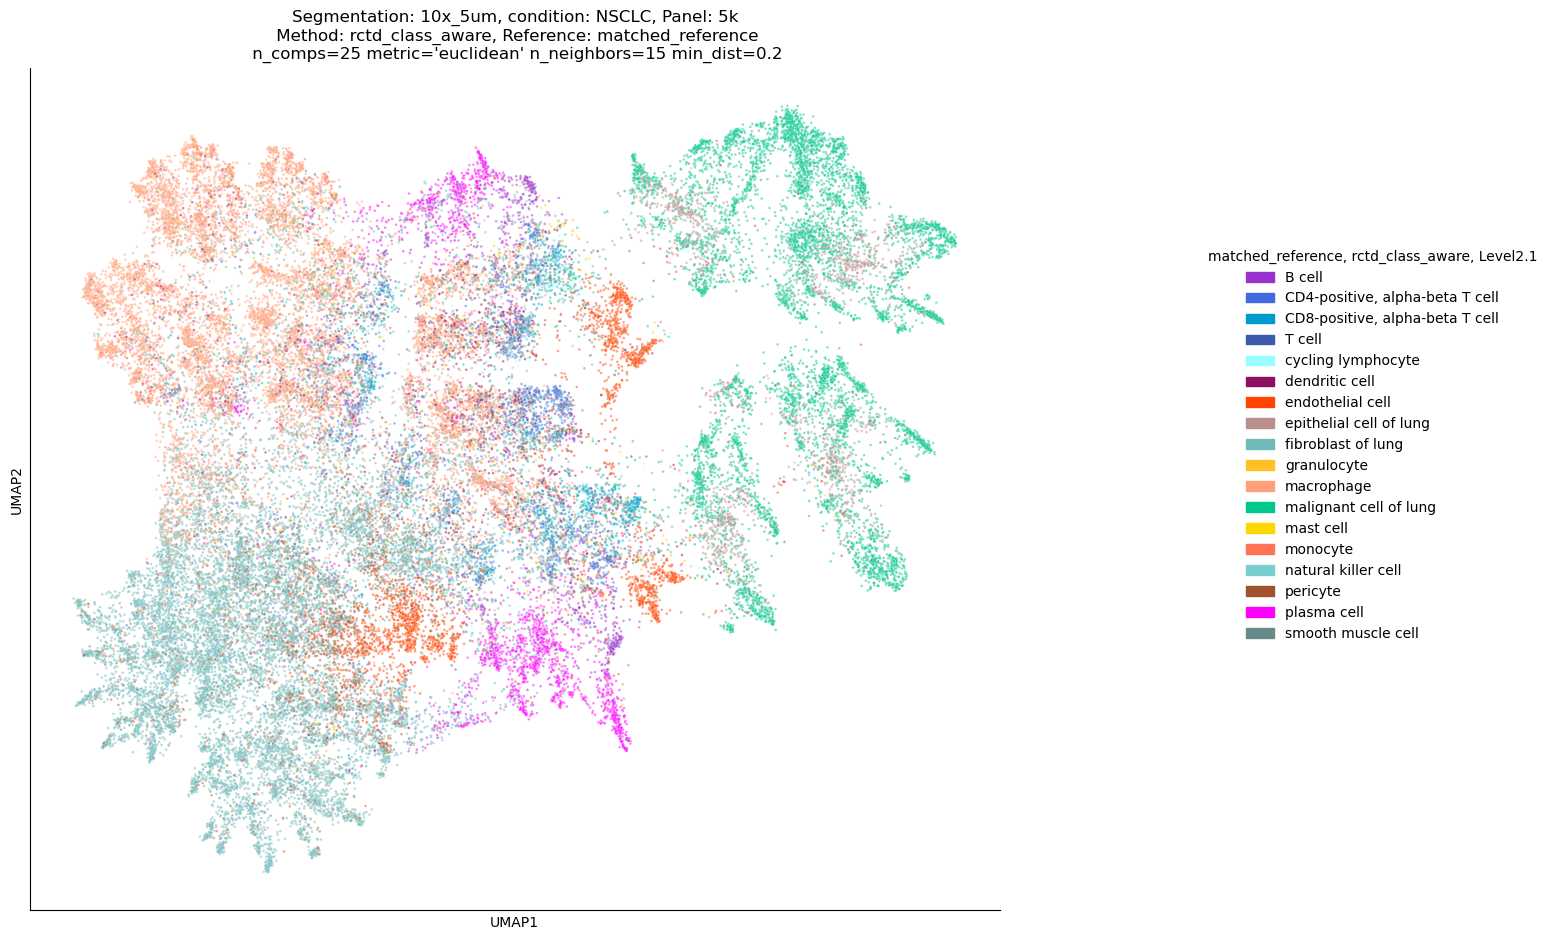

In [10]:
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path


xenium_dir = Path(cfg['xenium_processed_data_dir'])

# Params
n_comps = cfg['umap_n_comps']
n_neighbors = cfg['umap_n_neighbors']
min_dist = cfg['umap_min_dist']
metric = cfg['umap_metric']

list_n_comps = [25,50]
list_metric = ['euclidean','cosine']
list_n_neighbors = [15,50,100]
list_min_dist = [0.2,0.5]

# n_comps = 50
# metric = 'euclidean'
# n_neighbors = 50
# min_dist = 0.5

from itertools import product

for n_comps, metric, n_neighbors, min_dist in product(list_n_comps, list_metric, list_n_neighbors, list_min_dist):
    print(n_comps, metric, n_neighbors, min_dist)

    min_counts = 10
    min_features = 5
    max_counts = float("inf")
    max_features = float("inf")
    min_cells = 5
    # Set up argument parser
    # Access the arguments
    segmentation = '10x_5um'
    condition = 'NSCLC'
    panel = '5k'
    normalisation_method = "lognorm"  # fix this for now, even for sctransfrom args.normalisation_method
    layer = 'data'

    k = (segmentation,condition,panel,normalisation_method)
    name = '/'.join(k)

    panel = Path(f'/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/std_seurat_analysis/{segmentation}/{condition}/{panel}')
    genes = pd.read_csv('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/markers/Xenium_hLung_v1_metadata.csv')['Gene'].tolist()
    # genes = []

    # vars
    xenium_levels = ["segmentation", "condition", "panel", "donor", "sample", "cell_id"]
    segmentation = panel.parents[1].stem
    condition = panel.parents[0].stem

    # load umap
    ads = {}
    for donor in (donors := panel.iterdir()):
        for sample in (samples := donor.iterdir()):
            print(sample)

            k = (segmentation, condition, panel.stem, donor.stem, sample.stem)
            name_sample =  '/'.join(k)


            if segmentation == 'proseg_expected':
                sample_dir = xenium_dir / f'{name_sample}/raw_results'
            else:
                sample_dir = xenium_dir / f'{name_sample}/normalised_results/outs'

            sample_normalised_counts_path = sample / f"{normalisation_method}/normalised_counts/{layer}.parquet"
            sample_idx_path = sample / f"{normalisation_method}/normalised_counts/cells.parquet"
            
            # read normalised data
            X_normalised = pd.read_parquet(sample_normalised_counts_path)
            X_normalised.index = pd.read_parquet(sample_idx_path).iloc[:, 0]
            X_normalised.columns = X_normalised.columns.str.replace(".", "-")  # undo seurat renaming

            if len(genes):
                # load raw data to reapply lower bounds QC filters
                ads[k] = readwrite.read_xenium_sample(
                    sample_dir,
                    cells_as_circles=False,
                    cells_boundaries=False,
                    cells_boundaries_layers=False,
                    nucleus_boundaries=False,
                    cells_labels=False,
                    nucleus_labels=False,
                    transcripts=False,
                    morphology_mip=False,
                    morphology_focus=False,
                    aligned_images=False,
                    anndata=True,
                )
                if segmentation == "proseg_expected":
                    ads[k].obs_names = "proseg-" + ads[k].obs_names.astype(str)

                # filter cells
                ads[k] = ads[k][X_normalised.index, X_normalised.columns]
                ads[k].layers["X_normalised"] = X_normalised
                if layer != "scale_data":  # no need to sparsify scale_data which is dense
                    ads[k].layers["X_normalised"] = scipy.sparse.csr_matrix(ads[k].layers["X_normalised"])
            else:
                ads[k] = sc.AnnData(X_normalised)
                if layer != "scale_data":  # no need to sparsify scale_data which is dense
                    ads[k].X = scipy.sparse.csr_matrix(ads[k].X)


    # concatenate
    xenium_levels = ["segmentation", "condition", "panel", "donor", "sample"]
    for k in ads.keys():
        for i, lvl in enumerate(xenium_levels):
            ads[k].obs[lvl] = k[i]
    ad_merge = sc.concat(ads)

    # subset to genes
    if len(genes):
        genes_found = [
            g
            for g in ad_merge.var_names 
            if (g in genes) or (g.replace(".", "-") in genes)  # possible seurat renaming
        ]

        print(f"Found {len(genes_found)} out of {len(genes)} genes.")
        ad_merge = ad_merge[:, genes_found].copy()

        # reapply QC to avoid empty cells when using subset of genes
        preprocessing.preprocess(
            ad_merge,
            min_counts=min_counts,
            min_genes=min_features,
            max_counts=max_counts,
            max_genes=max_features,
            min_cells=min_cells,
            save_raw=False
        )
        # replace X
        ad_merge.X = ad_merge.layers['X_normalised']


    sc.pp.subsample(ad_merge,n_obs=50_000)
    # preprocess
    preprocessing.preprocess(
        ad_merge,
        normalize=False,
        log1p=False,
        scale="none",
        n_comps=n_comps,
        metric=metric,
        min_dist=min_dist,
        n_neighbors=n_neighbors,
        pca=True,
        umap=True,
        save_raw=False,
        min_counts=None,
        min_genes=None,
        max_counts=None,
        max_genes=None,
        min_cells=None,
    )

    obs = pd.DataFrame(ad_merge.obsm["X_umap"], index=ad_merge.obs_names, columns=["UMAP1", "UMAP2"])
    obs[xenium_levels] = ad_merge.obs[xenium_levels]
    obs["cell_id"] = obs.index

    # # save
    # df_umap = pd.DataFrame(ad_merge.obsm["X_umap"], index=ad_merge.obs_names, columns=["UMAP1", "UMAP2"])
    # df_umap[xenium_levels] = ad_merge.obs[xenium_levels]

    # df_umap.to_parquet(out_file)

    palette_dir = Path(cfg['xenium_metadata_dir'])
    cell_type_annotation_dir = Path(cfg['xenium_cell_type_annotation_dir'])

    reference = 'matched_reference'
    method = 'rctd_class_aware'
    color = 'Level2.1'
    cell_type_palette = palette_dir / 'col_palette_cell_types_combo.csv'
    panel_palette = palette_dir / 'col_palette_panel.csv'
    sample_palette = palette_dir / 'col_palette_donor.csv'

    if color == "sample":
        palette = pd.read_csv(sample_palette, index_col=0).iloc[:, 0]
    elif color == "panel":
        palette = pd.read_csv(panel_palette, index_col=0).iloc[:, 0]
    else:
        if color == 'Level2.1':
            palette_lvl2 = pd.read_csv(cell_type_palette)[['Level2', "cols_Level2"]].drop_duplicates().set_index('Level2').squeeze()
            palette = pd.read_csv(cell_type_palette)[[color, f"cols_{color}"]].drop_duplicates().set_index(color).squeeze()
            for (k,v) in palette_lvl2.items():
                if k not in palette.index:
                    palette[k] = palette_lvl2[k]
        else:
            palette = pd.read_csv(cell_type_palette)[[color, f"cols_{color}"]].drop_duplicates().set_index(color).squeeze()


    xenium_levels = ["segmentation", "condition", "panel", "donor", "sample", "cell_id"]
    # read cell type annotation
    annot = {}
    for donor in (donors := panel.iterdir()):
        for sample in (samples := donor.iterdir()):
            k = (
                segmentation,
                condition,
                panel.stem,
                donor.stem,
                sample.stem,
            )
            name = "/".join(k)

            annot[k] = {}
            annot_file = (
                cell_type_annotation_dir
                / name
                / f"{normalisation_method}/reference_based/{reference}/{method}/{color}/single_cell/labels.parquet"
            )
            # if annot_file.exists():
            annot[k][reference, method, color] = pd.read_parquet(annot_file).set_index("cell_id").iloc[:, 0]

    # merge annotations
    df_annot = {}
    for k in annot:
        if len(annot[k]):
            df_ = pd.DataFrame(annot[k])
            df_.columns = [col for col in df_.columns]
            df_annot[k] = df_
    df_annot = pd.concat(df_annot)
    df_annot.index.names = xenium_levels
    df_annot = df_annot.reset_index()

    # merge umap and cell type annotations
    df = pd.merge(obs, df_annot, on=xenium_levels, how="inner").dropna()

    params = (reference, method, color)

    if color == 'Level2.1':
        if condition == 'NSCLC':
            name_malignant = "malignant cell of lung"
        elif condition == 'breast':
            name_malignant = "malignant cell of breast"
        else:
            name_malignant = "malignant cell"

        ct_to_replace = df[params][df[params].str.contains("malignant")].unique()
        replace_map = dict([[ct,name_malignant] for ct in ct_to_replace])
        df[params] = df[params].replace(replace_map)


    title = f"Segmentation: {segmentation}, condition: {condition}, Panel: {panel.stem}\n Method: {method}, Reference: {reference}"
    title += f"\n {n_comps=} {metric=} {n_neighbors=} {min_dist=}"

    # plotting params, palette
    unique_labels = np.unique(df[params].dropna())
    palette = {u: palette[u] for u in unique_labels}
    legend_handles = [
    mpatches.Patch(color=color, label=label) for label, color in palette.items()
    ]

    # plot
    f = plt.figure(figsize=(12, 10))
    ax = plt.subplot()

    sns.scatterplot(
    data=df,
    x="UMAP1",
    y="UMAP2",
    s=3.5,
    alpha=0.5,
    hue=params,
    ax=ax,
    palette=palette,
    legend=False,
    )
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    sns.despine()

    plt.title(title)
    f.legend(
    handles=legend_handles,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title=params if isinstance(params, str) else ", ".join(params),
    frameon=False,
    )
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])
    # plt.savefig(out_file, dpi=300, bbox_inches="tight")
    plt.show()

    break


### per panel

In [ ]:
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path

results_dir = cfg['results_dir']
palette_dir = Path(cfg['xenium_metadata_dir'])
cell_type_annotation_dir = Path(cfg['xenium_cell_type_annotation_dir'])

# Params
n_comps = 50
n_neighbors = 50
min_dist = 0.3
metric = 'cosine'

# Set up argument parser
# Access the arguments
segmentation = 'proseg_expected'
condition = 'breast'
panel = 'breast'
normalisation_method = "lognorm"  # fix this for now, even for sctransfrom args.normalisation_method
layer = 'data'

k = (segmentation,condition,panel,normalisation_method)
name = '/'.join(k)

panel = Path(f'/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/std_seurat_analysis/{segmentation}/{condition}/{panel}')
embed_file = Path(results_dir) / f'embed_panel/{name}/umap_{layer}_{n_comps=}_{n_neighbors=}_{min_dist=}_{metric}.parquet'
reference = 'matched_reference_combo'
method = 'rctd_class_aware'
color = 'Level2'
cell_type_palette = palette_dir / 'col_palette_cell_types.csv'
panel_palette = palette_dir / 'col_palette_panel.csv'
sample_palette = palette_dir / 'col_palette_donor.csv'


if color == "sample":
    palette = pd.read_csv(sample_palette, index_col=0).iloc[:, 0]
elif color == "panel":
    palette = pd.read_csv(panel_palette, index_col=0).iloc[:, 0]
else:
    palette = pd.read_csv(cell_type_palette)[[color, f"cols_{color}"]].drop_duplicates().set_index(color).squeeze()


# vars
xenium_levels = ["segmentation", "condition", "panel", "donor", "sample", "cell_id"]
segmentation = panel.parents[1]
condition = panel.parents[0]

# load umap
obs = pd.read_parquet(embed_file)
obs["cell_id"] = obs.index


if color == "sample":
    # plot sample as color, no need to load annotations
    df = obs
    params = color
    title = f"Segmentation: {segmentation.stem}, condition: {condition.stem}, Panel: {panel.stem}"

else:
    # read cell type annotation
    annot = {}
    for donor in (donors := panel.iterdir()):
        for sample in (samples := donor.iterdir()):
            k = (
                segmentation.stem,
                condition.stem,
                panel.stem,
                donor.stem,
                sample.stem,
            )
            name = "/".join(k)

            annot[k] = {}
            annot_file = (
                cell_type_annotation_dir
                / name
                / f"{normalisation_method}/reference_based/{reference}/{method}/{color}/single_cell/labels.parquet"
            )
            # if annot_file.exists():
            annot[k][reference, method, color] = pd.read_parquet(annot_file).set_index("cell_id").iloc[:, 0]

    # merge annotations
    df_annot = {}
    for k in annot:
        if len(annot[k]):
            df_ = pd.DataFrame(annot[k])
            df_.columns = [col for col in df_.columns]
            df_annot[k] = df_
    df_annot = pd.concat(df_annot)
    df_annot.index.names = xenium_levels
    df_annot = df_annot.reset_index()

    # merge umap and cell type annotations
    df = pd.merge(obs, df_annot, on=xenium_levels, how="inner")

    params = (reference, method, color)
    title = f"Segmentation: {segmentation.stem}, condition: {condition.stem}, Panel: {panel.stem}\n Method: {method}, Reference: {reference}"


# plotting params, palette
unique_labels = np.unique(df[params].dropna())
palette = {u: palette[u] for u in unique_labels}
legend_handles = [
    mpatches.Patch(color=color, label=label) for label, color in palette.items()
]

# print(
#     f"Segmentation: {segmentation.stem}, condition: {condition.stem}, Panel: {panel.stem}, Method: {method}, Reference: {reference}, Level: {level}"
# )


# plot
f = plt.figure(figsize=(12, 10))
ax = plt.subplot()

sns.scatterplot(
    data=df,
    x="UMAP1",
    y="UMAP2",
    s=0.1,
    alpha=0.5,
    hue=params,
    ax=ax,
    palette=palette,
    legend=False,
)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
sns.despine()

plt.title(title)
f.legend(
    handles=legend_handles,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title=params if isinstance(params, str) else ", ".join(params),
    frameon=False,
)
plt.tight_layout(rect=[0, 0, 0.85, 0.95])
# plt.savefig(out_file, dpi=300, bbox_inches="tight")
plt.show()


### per panel facetted

In [ ]:
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path

results_dir = cfg['results_dir']
palette_dir = Path(cfg['xenium_metadata_dir'])

# Params
n_comps = 50
n_neighbors = 50
min_dist = 0.3
metric = 'cosine'

# Set up argument parser
# Access the arguments
segmentation = 'proseg'
condition = 'NSCLC'
panel = 'lung'
k = (segmentation,condition,panel)
name = '/'.join(k)

panel = Path(f'/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/{segmentation}/{condition}/{panel}')
embed_file = Path(results_dir) / f'embed_panel/{name}/umap_{n_comps=}_{n_neighbors=}_{min_dist=}_{metric}.parquet'
reference = 'matched_reference'
method = 'rctd_class_aware'
level = 'Level2'
cell_type_palette = palette_dir / 'col_palette_cell_types.csv'
panel_palette = palette_dir / 'col_palette_panel.csv'
sample_palette = palette_dir / 'col_palette_donor.csv'

if level == "sample":
    palette = pd.read_csv(sample_palette, index_col=0).iloc[:, 0]
elif level == "panel":
    palette = pd.read_csv(panel_palette, index_col=0).iloc[:, 0]
else:
    palette = pd.read_csv(cell_type_palette).set_index(level)[f'cols_{level}'].drop_duplicates()


# vars
xenium_levels = ["segmentation", "condition", "panel", "donor", "sample", "cell_id"]
segmentation = panel.parents[1]
condition = panel.parents[0]

# load umap
obs = pd.read_parquet(embed_file)
obs["cell_id"] = obs.index


if level == "sample":
    # plot sample as color, no need to load annotations
    df = obs
    params = level
    title = (
        f"Segmentation: {segmentation.stem}, condition: {condition.stem}, Panel: {panel.stem}"
    )

else:
    # read cell type annotation
    annot = {}
    for donor in (donors := panel.iterdir()):
        for sample in (samples := donor.iterdir()):
            k = (
                segmentation.stem,
                condition.stem,
                panel.stem,
                donor.stem,
                sample.stem,
            )
            name = "/".join(k)

            annot[k] = {}
            annot_file = (
                sample
                / f"cell_type_annotation/reference_based/{reference}/{method}/{level}/single_cell/labels.parquet"
            )
            if annot_file.exists():
                annot[k][reference, method, level] = (
                    pd.read_parquet(annot_file).set_index("cell_id").iloc[:, 0]
                )

    # merge annotations
    df_annot = {}
    for k in annot:
        if len(annot[k]):
            df_ = pd.DataFrame(annot[k])
            df_.columns = [col for col in df_.columns]
            df_annot[k] = df_
    df_annot = pd.concat(df_annot)
    df_annot.index.names = xenium_levels
    df_annot = df_annot.reset_index()

    # merge umap and cell type annotations
    df = pd.merge(obs, df_annot, on=xenium_levels, how="inner")

    params = (reference, method, level)
    title = f"Segmentation: {segmentation.stem}, condition: {condition.stem}, Panel: {panel.stem}\n Method: {method}, Reference: {reference}, Level: {level}"


# plotting params, palette
unique_labels = np.unique(df[params].dropna())
palette = {u: palette[u] for u in unique_labels}
legend_handles = [
    mpatches.Patch(color=color, label=label) for label, color in palette.items()
]

print(
    f"Segmentation: {segmentation.stem}, condition: {condition.stem}, Panel: {panel.stem}, Method: {method}, Reference: {reference}, Level: {level}"
)


# Calculate the number of rows and columns dynamically
n_plots = df['sample'].nunique()
n_cols = min(4, n_plots)
n_rows = int(np.ceil(n_plots / n_cols))

f, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
axs = axs.flat if n_plots > 1 else [axs]

for i, (sample, group) in enumerate(df.groupby('sample')):
    ax = axs[i]

    sns.scatterplot(
        data=df,
        x="UMAP1",
        y="UMAP2",
        s=0.1,
        alpha=0.5,
        hue=params,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    sns.despine()

# Hide unused subplots
for j in range(n_plots, len(axs)):
    f.delaxes(axs[j])


    plt.title(title)
    f.legend(
        handles=legend_handles,
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        title=params if isinstance(params, str) else ", ".join(params),
        frameon=False,
    )
    
plt.tight_layout(rect=[0, 0, 0.85, 0.95])
# plt.savefig(out_file, dpi=300, bbox_inches="tight")
plt.show()